In [5]:
import numpy as np
from scipy.stats import chi2

from data.data_reading import data_reading
from data.data_processing import data_processing

from ruspy.simulation.simulation import simulate
from ruspy.simulation.value_zero import calc_ev_0, discount_utility
from ruspy.estimation.estimation import estimate
from aux_01 import create_sections
from ruspy.estimation.estimation_cost_parameters import (
    lin_cost,
    cost_func,
    create_transition_matrix,
    calc_fixp,
    choice_prob
)
from worst_case_probs import calc_fixp_worst
import pickle as pkl
import glob

In [6]:
from zipfile import ZipFile
from pathlib import Path

def get_file(fname):

    if not isinstance(fname, Path):
        fname = Path(fname)
    
    fname_zip = Path(fname).with_suffix('.zip') 
    fname_pkl = Path(fname).with_suffix('.pkl')

    if not os.path.exists(fname_pkl):   
        with ZipFile(fname_zip, 'r') as zipObj:
           zipObj.extractall(Path(fname).parent)
        
    return pkl.load(open(fname_pkl, 'rb'))

In [7]:
# Beta is set almost to one, as the agents objective is to maximize average cost.
beta = 0.9999
# 200 buses should be enough to gurantee convergence.
num_buses = 200
# Set the number of simulated periods to 80000. The first plot shows the convergence at this point.
num_periods = 70000

# Paramters for plotting
gridsize = 1000
num_points = int(num_periods/gridsize) + 1

In [8]:
# dict_polcies = get_file("../pre_processed_data/results.pkl")
# omega_range = np.linspace(0, 0.99, 100)
# worst_evs = []
# worst_trans_mats = []
# for omega in omega_range:
#     worst_evs += [dict_polcies[omega][0]]
#     worst_trans_mats += [dict_polcies[omega][1]]

In [9]:
# trans_mat_ml = worst_trans_mats[0]
# ev_ml = worst_evs[0]
# ev_worst = worst_evs[-1]

In [10]:
# num_states = ev_ml.shape[0]
# params = np.loadtxt("../pre_processed_data/parameters/rust_cost_params.txt")
# p_ml = np.loadtxt("../pre_processed_data/parameters/rust_trans_probs.txt")
# costs = cost_func(num_states, lin_cost, params)

In [11]:
# choice_ml = choice_prob(ev_ml, costs, beta)
# choice_worst = choice_prob(ev_worst, costs, beta)

The following figure shows the replacement probability curve given an expected value fixed point. It therefore shows the probability of replacement of an agent using these fixed points as their belief on the future. For the construction of the uncertainty set, the mean number of observation 4292/78 was used. The transition probabilities and cost paramters are the one's from Rust paper with discreteziation 5000 miles.

* Here we can set up changes in the uncertainty set through varying omega for given data or keeping omega fixed but vary the data size. This allows to trace out the effect of ambiguity.

In [12]:
# state_range = 400
# y_0 = 0
# y_1 = choice_ml[-1, 1]

# states = range(state_range)

# fig, ax = plt.subplots(1, 1)
# ax.set_ylim([y_0, y_1])
# ax.set_ylabel(r"Probability of replacement")
# ax.set_xlabel(r"State of the bus")
# ax.plot(states, choice_ml[:state_range, 1], label='Nominal strategy')
# ax.plot(states, choice_worst[:state_range, 1], label='Robust strategy with $\omega = 0.99$')


# plt.legend()
# fig.savefig('{:}/fig-application-replacement-probabilities'.format(DIR_FIGURES))

In [13]:
dict_policies = get_file("../pre_processed_data/results_1000_10_10.pkl")
omega_range = np.linspace(0, 0.99, 12)
worst_evs = []
worst_trans_mats = []
for omega in omega_range:
    worst_evs += [dict_policies[omega][0]]
    worst_trans_mats += [dict_policies[omega][1]]

In [14]:
trans_mat_ml = worst_trans_mats[0]
trans_mat_worst = worst_trans_mats[-1]
ev_ml = worst_evs[0]
ev_54 = dict_policies[0.54][0]
ev_worst = worst_evs[-1]

In [15]:
num_states = ev_ml.shape[0]
params = np.array([10, 10])
p_ml = np.loadtxt("../pre_processed_data/parameters/p_1000_4.txt")
costs = cost_func(num_states, lin_cost, params)

In [16]:
choice_ml = choice_prob(ev_ml, costs, beta)
choice_054 = choice_prob(ev_54, costs, beta)
choice_worst = choice_prob(ev_worst, costs, beta)

The following figure shows a stylized example for the demonstration of the shift of the replacement probability curve. For the construction of the uncertainty set, the mean number of observation 4292/78 was used. The transition probabilities are estimated from Rust's paper with discreteziation 1000 miles. The cost parameters are (10, 10), which are in contrast to the ones estimated by Rust (10, 2.27).

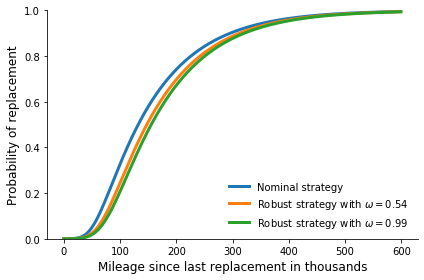

In [17]:
state_range = 600
y_0 = 0
y_1 = 1

states = range(state_range)

fig, ax = plt.subplots(1, 1)
ax.set_ylim([y_0, y_1])
ax.set_ylabel(r"Probability of replacement")
ax.set_xlabel(r"Mileage since last replacement in thousands")
ax.plot(states, choice_ml[:state_range, 1], label='Nominal strategy')
ax.plot(states, choice_054[:state_range, 1], label='Robust strategy with $\omega = 0.54$')
ax.plot(states, choice_worst[:state_range, 1], label='Robust strategy with $\omega = 0.99$')


plt.legend()
fig.savefig('{:}/fig-application-replacement-probabilities-stylized'.format(DIR_FIGURES))

In [28]:
file_list = sorted(glob.glob("../pre_processed_data/df_threshold/df*"))
if len(file_list) != 0:
    means_robust_strat = np.array([])
    for file in file_list:
        df = pkl.load(open(file,"rb"))
        means_robust_strat = np.append(means_robust_strat, np.mean(df[df["decision"] == 1]["state"]))
else:
    means_robust_strat = pkl.load(open("../pre_processed_data/df_threshold/means_robust.pkl", "rb"))
means_discrete = np.around(means_robust_strat).astype(int)

In [29]:
omega_range = np.linspace(0, 0.99, 12)

In [30]:
means_ml = np.full(len(omega_range), np.around(means_robust_strat[0])).astype(int)

In [31]:
omega_sections, state_sections = create_sections(means_discrete, omega_range)

The following figure shows the average state of replacement observed in simulated data. The means are rounded due to standard rounding rules. The underlying transition matrix governing the stochastic process of the milage increase is the ML estimate of Rust paper with discretization of 1000 miles. The mapping for the robust strategies from $\omega$ to $\rho$ is done with the mean number of observations 4292/389. The cost parameters are (10, 10).

## Should we vary training sample and show effect?

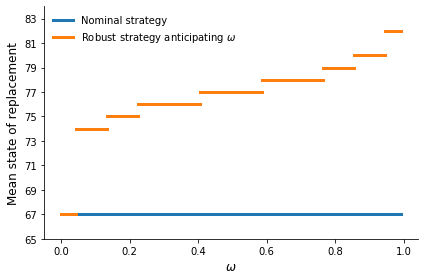

In [33]:
y_0 = state_sections[0][0] - 2
y_1 = state_sections[-1][-1] + 2

fig, ax = plt.subplots(1, 1)
ax.set_ylim([y_0, y_1])
plt.yticks(range(y_0, y_1, 2))
ax.set_ylabel(r"Mean state of replacement")
ax.set_xlabel(r"$\omega$")
ax.plot(omega_range, means_ml, label='Nominal strategy')
for j, i in enumerate(omega_sections[:-1]):
    ax.plot(i, state_sections[j], color='#ff7f0e')
ax.plot(omega_sections[-1], state_sections[-1], color='#ff7f0e', label="Robust strategy anticipating $\omega$")


plt.legend()
fig.savefig('{:}/fig-application-replacement-thresholds'.format(DIR_FIGURES))

In [34]:
try:
    df_trans_99_ev_ml = pkl.load(open("../pre_processed_data/df_trans_99_ev_0.0.pkl", "rb"))
    # Calculate the expected value at time zero
    v_exp_ml = np.full(num_points, calc_ev_0(df_trans_99_ev_ml, ev_ml))
    v_exp_worst = np.full(num_points, calc_ev_0(df_trans_99_ev_ml, ev_worst))
    # Calculate the value at time 0 by discounting the utility
    v_disc_ml = discount_utility(df_trans_99_ev_ml, gridsize, beta)
except:
    v_exp_ml, v_exp_worst, v_disc_ml = pkl.load(open("../pre_processed_data/evs_convergence.pkl", "rb"))

In [35]:
# Create a numpy array of the periods for plotting
periods = np.arange(0, num_periods + gridsize, gridsize)

The following figure shows the performance of the nominal strategy, when the worst case transition matrix of ω=0.99 is underlying. The cost and transition parameters are from the 5000 miles discretization. The two benchmarks are the expected value of an optimal strategy, when the underlying transition matrix is the ML estimate or the worst case transition matrix for omega=0.99. The number of observations for the mapping between ρ and ω is again the mean 4292/78.

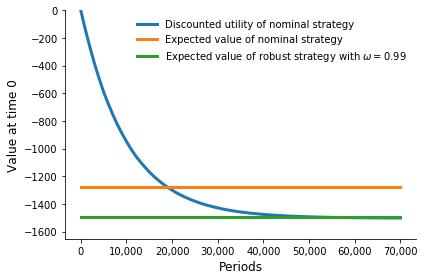

In [36]:
fig, ax = plt.subplots(1, 1)
ax.set_ylim([1.1 * v_disc_ml[-1], 0])
ax.set_ylabel(r"Value at time 0")
ax.set_xlabel(r"Periods")
ax.get_xaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
ax.plot(periods, v_disc_ml, label='Discounted utility of nominal strategy')
ax.plot(periods, v_exp_ml, label='Expected value of nominal strategy')
ax.plot(periods, v_exp_worst, label='Expected value of robust strategy with $\omega = 0.99$')

plt.legend()
fig.savefig('{:}/fig-application-performance-nominal-strategy'.format(DIR_FIGURES))

In [21]:
file_list = sorted(glob.glob("../pre_processed_data/strategies/nominal_strategy/df*"))
if len(file_list) != 0:
    nominal_costs = np.zeros(len(omega_range))
    for j, file in enumerate(file_list):
        df = pkl.load(open(file,"rb"))
        nominal_costs[j] = discount_utility(df, gridsize, beta)[-1]
else:
    nominal_costs = pkl.load(open("../pre_processed_data/strategies/nominal_strategy/nominal_costs.pkl", "rb"))

In [23]:
file_list = sorted(glob.glob("../pre_processed_data/strategies/54_strategy/df*"))
if len(file_list) != 0:
    robust_54_costs = np.zeros(len(omega_range))
    for j, file in enumerate(file_list):
        df = pkl.load(open(file,"rb"))
        robust_54_costs[j] = discount_utility(df, gridsize, beta)[-1]
else:
    robust_54_costs =  pkl.load(open("../pre_processed_data/strategies/54_strategy/robust_54_costs.pkl", "rb"))

In [24]:
file_list = sorted(glob.glob("../pre_processed_data/strategies/opt_strategy/df*"))
if len(file_list) != 0:
    opt_costs = np.zeros(len(omega_range))
    for j, file in enumerate(file_list):
        df = pkl.load(open(file,"rb"))
        opt_costs[j] = discount_utility(df, gridsize, beta)[-1]
else:
    opt_costs = pkl.load(open("../pre_processed_data/strategies/opt_strategy/opt_costs.pkl", "rb"))

The following figure show the current value of different strategies given the worst case transition matrix according to the $\omega$ on the x-axis. The performance is averaged over 200 buses and each bus drives over a 70000 periods. The cost parameters are again (10, 10) and the ML estimate is from group 4 with a discretization of 1000 miles.

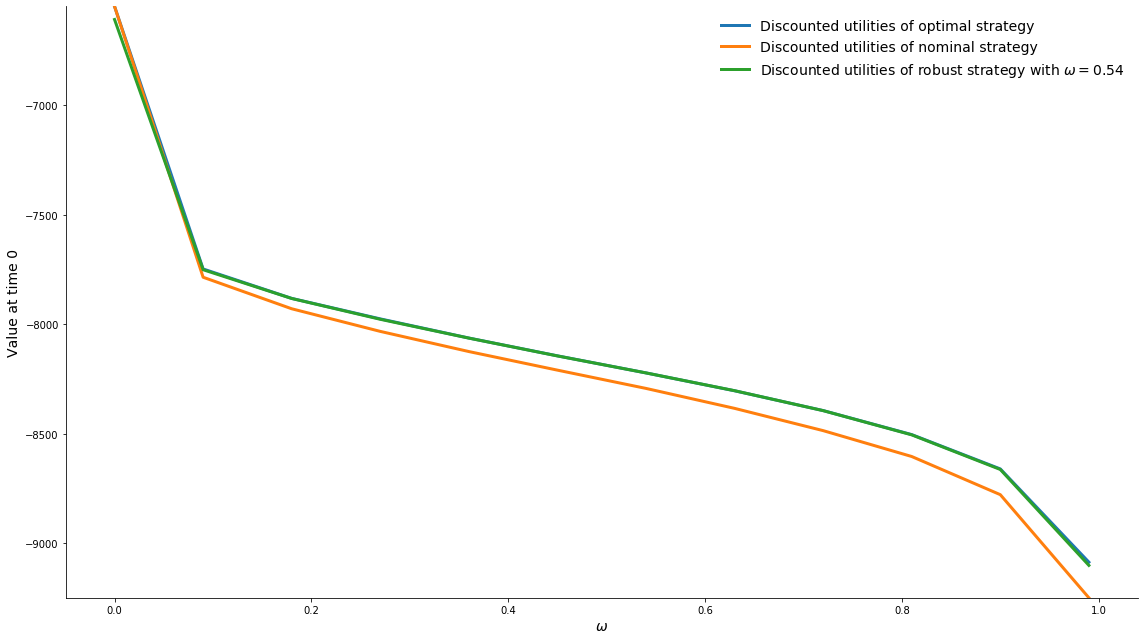

In [26]:
fig, ax = plt.subplots(1, 1, figsize=(16, 9))
ax.set_ylim([nominal_costs[-1], nominal_costs[0]])
ax.set_ylabel(r"Value at time 0", fontsize=14)
ax.set_xlabel(r"$\omega$", fontsize=14)
ax.plot(omega_range, opt_costs, label='Discounted utilities of optimal strategy')
ax.plot(omega_range, nominal_costs, label='Discounted utilities of nominal strategy')
ax.plot(omega_range, robust_54_costs, label='Discounted utilities of robust strategy with $\omega = 0.54$')

plt.legend(fontsize=14)
fig.savefig('{:}/fig-application-performance'.format(DIR_FIGURES))